
# Assignment 6
Halka Hanna


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, ARIMA
from utilsforecast.losses import rmse, mae, smape
from statsforecast.models import AutoETS
from statsforecast.arima import ARIMASummary
from matplotlib.ticker import MaxNLocator
from statsmodels.stats.diagnostic import acorr_ljungbox
from utilsforecast.plotting import plot_series as plot_series_utils
from fpppy.utils import plot_series

import warnings
warnings.filterwarnings('ignore')

In [40]:
def plot_base(col, title, xlabel, ylabel):
    plt.figure(figsize=(12, 3))
    plt.plot(col, color='#F3D407')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

---
## Daily Temperature

In [41]:
tempt = pd.read_csv('../data/daily_tempt.csv')
tempt['data_ind'] = tempt['Date']
tempt = tempt.set_index('data_ind')
tempt.index = pd.to_datetime(tempt.index)

### 1 Stationarity and Differencing

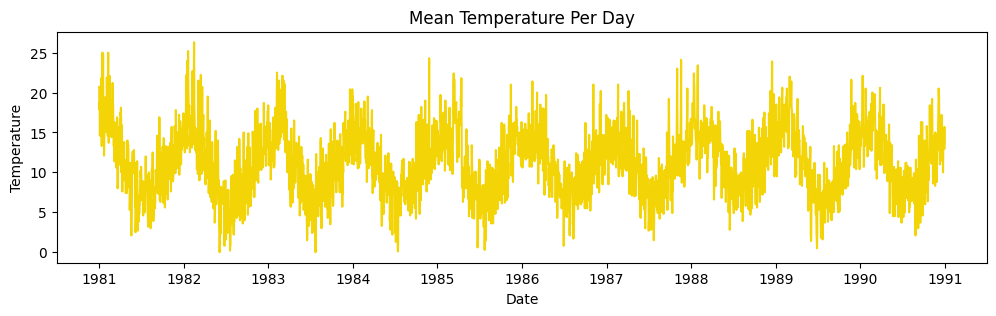

In [42]:
plot_base(tempt['mean-tempt'], 'Mean Temperature Per Day', 'Date', 'Temperature')

In [43]:
result = adfuller(tempt['mean-tempt'])
print(f'p-value = {result[1]:.5f}')

p-value = 0.00025


In this graphic we have static variance, our p-value = 0.00025 so our series is stationary.
So we don't need any transformation.

In [44]:
y_seasonal = tempt['mean-tempt'].diff(365).dropna()
result = adfuller(y_seasonal)
print(f"ADF seasonal diff p-value = {result[1]:.5f}")

y_seasonal_first = y_seasonal.diff().dropna()
result = adfuller(y_seasonal_first)
print(f"ADF seasonal+first diff p-value = {result[1]:.5f}")

ADF seasonal diff p-value = 0.00000
ADF seasonal+first diff p-value = 0.00000


### 2 Manual Model Selection

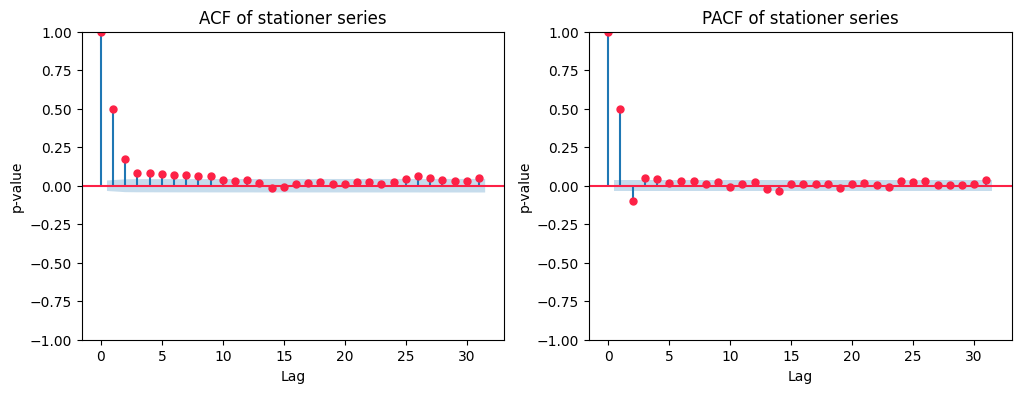

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(y_seasonal, lags=31, ax=axes[0], color='#FD2146')
axes[0].set_title('ACF of stationer series')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('p-value')

plot_pacf(y_seasonal, lags=31, ax=axes[1], color='#FD2146')
axes[1].set_title('PACF of stationer series')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('p-value')

plt.show()

### 3 Estimation and AutoARIMA

In [46]:
train_df = tempt.loc[tempt.index < '1988-01-01']
val_df = tempt.loc[tempt.index >= '1988-01-01']

In [47]:
train = train_df[['mean-tempt']].reset_index()
train['unique_id'] = 'tempt'
train.rename(columns={'data_ind': 'ds', 'mean-tempt': 'y'}, inplace=True)
train = train[['unique_id', 'ds', 'y']]

val = val_df[['mean-tempt']].reset_index()
val['unique_id'] = 'tempt'
val.rename(columns={'data_ind': 'ds', 'mean-tempt': 'y'}, inplace=True)
val = val[['unique_id', 'ds', 'y']]

In [ ]:
models = [
  ARIMA(order=(0, 1, 1), seasonal_order=(0, 1, 1), season_length=31, alias="arima012011"), # approx 3h if 365
  ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 1), season_length=31, alias="arima210011"),
  AutoARIMA(stepwise=False, approximation=False, alias="auto", season_length=31),
]

sf = StatsForecast(models=models, freq="D", n_jobs=-1)
sf.fit(df=train)
summaries = []

for model in sf.fitted_[0]:
  summary_model = {
    "model": model,
    "Orders": ARIMASummary(model.model_),
    "sigma2": model.model_["sigma2"],
    "loglik": model.model_["loglik"],
    "aic": model.model_["aic"],
    "aicc": model.model_["aicc"],
    "bic": model.model_["bic"],
  }
  summaries.append(summary_model)
pd.DataFrame(sorted(summaries, key=lambda d: d["aicc"]))

In [ ]:
forecasts = sf.forecast(
  df=train[["ds", "y", "unique_id"]], h=len(val['y']), fitted=True, level=[80, 95]
)
fitted_values = sf.forecast_fitted_values()
insample_forecasts = fitted_values["auto"]
residuals = fitted_values["y"] - insample_forecasts

fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax1.plot(train["ds"], residuals, marker="o")
ax1.set_ylabel("Innovation Residuals")
ax1.set_xlabel("Year")
plot_acf(
  residuals, ax2, zero=False,
  bartlett_confint=False, auto_ylims=True
)
ax3.hist(residuals, bins=20)
ax3.set_ylabel("count")
ax3.set_xlabel("residuals")
plt.show()

In [ ]:
ljung_box = acorr_ljungbox(residuals, lags=[31], model_df=4)
ljung_box

In [ ]:
plot_series(
  df=train,
  forecasts_df=forecasts.reset_index()[
    [
      "unique_id", "ds", "auto",
      "auto-lo-80", "auto-lo-95",
      "auto-hi-80", "auto-hi-95",
    ]
  ],
  level=[80, 95], rm_legend=False,
  xlabel="Year", ylabel="Mean Temperature",
  title="Daily mean temperature"
)

### 4 ARIMA vs ETS

In [ ]:
train["y"] /= 1e6

models = [AutoARIMA(), AutoETS()]
sf = StatsForecast(models=models, freq="D", n_jobs=-1)
cv_forecasts = sf.cross_validation(h=1, n_windows=10, df=tempt_df)
error_metrics = [rmse, mae, smape]
errors = pd.DataFrame()
for error_metric in error_metrics:
  error = error_metric(cv_forecasts.reset_index(),
    models=["AutoARIMA", "AutoETS"])
  error.rename(index={0: error_metric.__name__}, inplace=True)
  errors = pd.concat((errors, error))
errors.drop(columns="unique_id").T

In [ ]:
stop

---
## Weekly CO2


In [ ]:
co2 = pd.read_csv('../data/weekly_co2.csv')
co2 = co2[['Date', 'average']]
co2['data_ind'] = co2['Date']
co2 = co2.set_index('data_ind')
co2.index = pd.to_datetime(co2.index)

### 1 Stationarity and Differencing

In [ ]:
plot_base(co2['average'], 'Average Co2 Per Week', 'Date', 'Co2')

In [ ]:
result = adfuller(co2['average'])
print(f'p-value = {result[1]:.5f}')

In this graphic we have static variance, but our p-value = 0.98798
so our series is non-stationary.


In [ ]:
y_seasonal = co2['average'].diff(52).dropna()
result = adfuller(y_seasonal)
print(f"ADF seasonal diff p-value = {result[1]:.5f}")

y_seasonal_first = y_seasonal.diff().dropna()
result = adfuller(y_seasonal_first)
print(f"ADF seasonal+first diff p-value = {result[1]:.5f}")

### 2 Manual Model Selection

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(y_seasonal, lags=104, ax=axes[0], color='#FD2146')
axes[0].set_title('ACF of stationer series')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('p-value')

plot_pacf(y_seasonal, lags=104, ax=axes[1], color='#FD2146')
axes[1].set_title('PACF of stationer series')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('p-value')

plt.show()

### 3 Estimation and AutoARIM

In [ ]:
co2_df = co2[['average']].reset_index()
co2_df['unique_id'] = 'co2'
co2_df.rename(columns={'data_ind': 'ds', 'average': 'y'}, inplace=True)
co2_df = co2_df[['unique_id', 'ds', 'y']]
co2_df.head(5)

ARIMA(order=(p=0, d=1, q=1), seasonal_order=(P=1, D=1, Q=1))

m=52

In [ ]:
models = [
  ARIMA(order=(0, 1, 2), seasonal_order=(0, 1, 1), season_length=12, alias="arima012011"),
  ARIMA(order=(2, 1, 0), seasonal_order=(0, 1, 1), season_length=12, alias="arima210011"),
  AutoARIMA(stepwise=False, approximation=False, alias="auto", season_length=12),
]

sf = StatsForecast(models=models, freq="W", n_jobs=-1)
sf.fit(df=co2_df)
summaries = []

for model in sf.fitted_[0]:
  summary_model = {
    "model": model,
    "Orders": ARIMASummary(model.model_),
    "sigma2": model.model_["sigma2"],
    "loglik": model.model_["loglik"],
    "aic": model.model_["aic"],
    "aicc": model.model_["aicc"],
    "bic": model.model_["bic"],
  }
  summaries.append(summary_model)

pd.DataFrame(sorted(summaries, key=lambda d: d["aicc"]))

In [ ]:
forecasts = sf.forecast(
  df=co2_df[["ds", "y", "unique_id"]], h=36, fitted=True, level=[80, 95]
)
fitted_values = sf.forecast_fitted_values()
insample_forecasts = fitted_values["auto"]
residuals = fitted_values["y"] - insample_forecasts

fig = plt.figure()
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax1.plot(tempt_df["ds"], residuals, marker="o")
ax1.set_ylabel("Innovation Residuals")
ax1.set_xlabel("Year")
plot_acf(
  residuals, ax2, zero=False,
  bartlett_confint=False, auto_ylims=True
)
ax3.hist(residuals, bins=20)
ax3.set_ylabel("count")
ax3.set_xlabel("residuals")
plt.show()

In [ ]:
ljung_box = acorr_ljungbox(residuals, lags=[12], model_df=4)
ljung_box

In [ ]:
plot_series(
  df=co2_df,
  forecasts_df=forecasts.reset_index()[
    [
      "unique_id", "ds", "auto",
      "auto-lo-80", "auto-lo-95",
      "auto-hi-80", "auto-hi-95",
    ]
  ],
  level=[80, 95], rm_legend=False,
  xlabel="Month [1M]", ylabel="Number of people (millions)",
  title="US employment: leisure and hospitality"
)

### 4 ARIMA vs ETS

In [ ]:
co2_df["y"] /= 1e6

models = [AutoARIMA(), AutoETS()]
sf = StatsForecast(models=models, freq="W", n_jobs=-1)
cv_forecasts = sf.cross_validation(h=1, n_windows=10, df=co2_df)
error_metrics = [rmse, mae, smape]
errors = pd.DataFrame()
for error_metric in error_metrics:
  error = error_metric(cv_forecasts.reset_index(),
    models=["AutoARIMA", "AutoETS"])
  error.rename(index={0: error_metric.__name__}, inplace=True)
  errors = pd.concat((errors, error))
errors.drop(columns="unique_id").T

---
## Hourly AEP

In [ ]:
aep = pd.read_csv('../data/hourly_aep.csv')
aep['data_ind'] = aep['Date']
aep = aep.set_index('data_ind')
aep.index = pd.to_datetime(aep.index)

### 1 Stationarity and Differencing


In [ ]:
plot_base(aep['AEP_MW'], 'AEP Per Hour', 'Date', 'MW')

In [ ]:
result = adfuller(aep['AEP_MW'])
print(f'p-value = {result[1]:.5f}')

In this graphic we have static variance, our p-value = 0.00000 so our series is stationary.
So we don't need any transformation.

In [ ]:
y_seasonal = aep['AEP_MW'].diff(4464*2).dropna()
result = adfuller(y_seasonal)
print(f"ADF seasonal diff p-value = {result[1]:.5f}")

y_seasonal_first = y_seasonal.diff().dropna()
result = adfuller(y_seasonal_first)
print(f"ADF seasonal+first diff p-value = {result[1]:.5f}")

### 2 Manual Model Selection

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(y_seasonal, lags=31, ax=axes[0], color='#FD2146')
axes[0].set_title('ACF of stationer series')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('p-value')

plot_pacf(y_seasonal, lags=31, ax=axes[1], color='#FD2146') # 12*2*31
axes[1].set_title('PACF of stationer series')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('p-value')

plt.show()

### 3 Estimation and AutoARIM

In [ ]:
aep_df = aep[['AEP_MW']].reset_index()
aep_df['unique_id'] = 'mw'
aep_df.rename(columns={'data_ind': 'ds', 'AEP_MW': 'y'}, inplace=True)
aep_df = aep_df[['unique_id', 'ds', 'y']]
aep_df.head(5)

In [ ]:
models = [
  ARIMA(order=(0, 1, 2), seasonal_order=(2, 1, 2), season_length=24, alias="arima012011"),
  ARIMA(order=(2, 1, 0), seasonal_order=(1, 3, 15), season_length=24, alias="arima210011"),
  AutoARIMA(stepwise=False, approximation=False, alias="auto", season_length=24),
]

sf = StatsForecast(models=models, freq="h", n_jobs=-1)
sf.fit(df=aep_df)
summaries = []

for model in sf.fitted_[0]:
  summary_model = {
    "model": model,
    "Orders": ARIMASummary(model.model_),
    "sigma2": model.model_["sigma2"],
    "loglik": model.model_["loglik"],
    "aic": model.model_["aic"],
    "aicc": model.model_["aicc"],
    "bic": model.model_["bic"],
  }
  summaries.append(summary_model)

pd.DataFrame(sorted(summaries, key=lambda d: d["aicc"]))

In [ ]:
forecasts = sf.forecast(
  df=aep_df[["ds", "y", "unique_id"]], h=36, fitted=True, level=[80, 95]
)
fitted_values = sf.forecast_fitted_values()
insample_forecasts = fitted_values["auto"]
residuals = fitted_values["y"] - insample_forecasts

fig = plt.figure()
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax1.plot(tempt_df["ds"], residuals, marker="o")
ax1.set_ylabel("Innovation Residuals")
ax1.set_xlabel("Year")
plot_acf(
  residuals, ax2, zero=False,
  bartlett_confint=False, auto_ylims=True
)
ax3.hist(residuals, bins=20)
ax3.set_ylabel("count")
ax3.set_xlabel("residuals")
plt.show()

In [ ]:
ljung_box = acorr_ljungbox(residuals, lags=[24], model_df=4)
ljung_box

In [ ]:
plot_series(
  df=aep_df,
  forecasts_df=forecasts.reset_index()[
    [
      "unique_id", "ds", "auto",
      "auto-lo-80", "auto-lo-95",
      "auto-hi-80", "auto-hi-95",
    ]
  ],
  level=[80, 95], rm_legend=False,
  xlabel="Month [1M]", ylabel="Number of people (millions)",
  title="US employment: leisure and hospitality"
)

### 4 ARIMA vs ETS

In [ ]:
aep_df["y"] /= 1e6

models = [AutoARIMA(), AutoETS()]
sf = StatsForecast(models=models, freq="h", n_jobs=-1)
cv_forecasts = sf.cross_validation(h=1, n_windows=10, df=aep_df)
error_metrics = [rmse, mae, smape]
errors = pd.DataFrame()
for error_metric in error_metrics:
  error = error_metric(cv_forecasts.reset_index(),
    models=["AutoARIMA", "AutoETS"])
  error.rename(index={0: error_metric.__name__}, inplace=True)
  errors = pd.concat((errors, error))
errors.drop(columns="unique_id").T

---

Для всіх трьох часових рядів ARIMA і ETS справляються майже однаково
для `tempt_df` ETS трохи виграє, а більшості `co2_df` та `aep_df` важко сказати хто кращею